======================================Long Short-Term Memory (LSTM)====================================

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

##### The key distinction between vanilla RNNs and LSTMs is that the latter support **gating of the hidden state**.

![LSTM image 1](./Images/LSTM_1.png)

##### Input Gate, Forget Gate, and Output Gate
$$
\begin{aligned}
I_t &= \sigma(X_t W_{xi} + H_{t-1} W_{hi} + b_i), \\
F_t &= \sigma(X_t W_{xf} + H_{t-1} W_{hf} + b_f), \\
O_t &= \sigma(X_t W_{xo} + H_{t-1} W_{ho} + b_o)
\end{aligned}
$$

##### Input Node
$$
\begin{aligned}
\tilde{C}_t &= \tanh(X_t W_{xc} + H_{t-1} W_{hc} + b_c)
\end{aligned}
$$

##### Memory Cell Internal State
$$
\begin{aligned}
C_t &= F_t \odot C_{t-1} + I_t \odot \tilde{C}_t, \\
H_t &= O_t \odot \tanh(C_t)
\end{aligned}
$$



In [2]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

In [ ]:
@d2l.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
    # inputs shape: (num_steps, batch_size, num_inputs/vocab_size)
    if H_C is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
        C = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
    else:
        H, C = H_C
    outputs = []
    for X in inputs:
        # X shape: (batch_size, num_inputs)
        I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                        torch.matmul(H, self.W_hi) + self.b_i)
        F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                        torch.matmul(H, self.W_hf) + self.b_f)
        O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                        torch.matmul(H, self.W_ho) + self.b_o)
        C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                           torch.matmul(H, self.W_hc) + self.b_c)
        C = F * C + I * C_tilde
        H = O * torch.tanh(C)
        # H shape: (batch_size, num_hiddens)
        # LSTMScratch is a low-level scratch impelmentation, outputs is a list. 
        # The caller will stack into a tensor: (num_steps, batch_size, num_hiddens)
        # caller like d2l.RNNLMScratch or nn.LSTM should return tensor
        outputs.append(H)
    return outputs, (H, C)

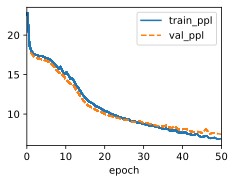

In [ ]:
# num_steps: length of each training sequence
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

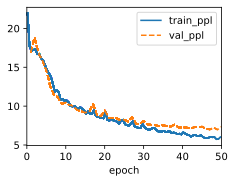

In [ ]:
# Concise Implementation
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

# num_steps is decided by the data loader, see above: data = d2l.TimeMachine(batch_size=1024, num_steps=32)

In [ ]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has it a move the time '

===============================Gated Recurrent Units (GRU)==============================

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

![GRU](./Images/GRU_1.png)

1. **Reset gate:**
$
R_t = \sigma(X_t W_{xr} + H_{t-1} W_{hr} + b_r)
$

2. **Update gate:**
$
Z_t = \sigma(X_t W_{xz} + H_{t-1} W_{hz} + b_z)
$

3. **Candidate hidden state:**
$
\tilde{H}_t = \tanh(X_t W_{xh} + (R_t \odot H_{t-1}) W_{hh} + b_h)
$

4. **New hidden state:**
$
H_t = Z_t \odot H_{t-1} + (1 - Z_t) \odot \tilde{H}_t
$


In [ ]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state

In [ ]:
@d2l.add_to_class(GRUScratch)
def forward(self, inputs, H=None):
    # inputs shape: (num_steps, batch_size, num_inputs/vocab_size)
    if H is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
    outputs = []
    for X in inputs:
        # X shape: (batch_size, num_inputs)
        Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                        torch.matmul(H, self.W_hz) + self.b_z)
        R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                        torch.matmul(H, self.W_hr) + self.b_r)
        H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                           torch.matmul(R * H, self.W_hh) + self.b_h)
        H = Z * H + (1 - Z) * H_tilde
        outputs.append(H)
    return outputs, H

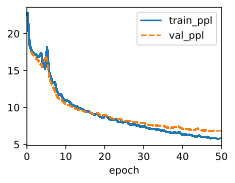

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [ ]:
# Concise Implementation

class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)

gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [ ]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has i the the the the t'

=================================Deep Recurrent Neural Networks=================================

![Deep RNN](./Images/Deep-RNN_1.png)

1. **Hidden state at layer \( l \):**
$
\mathbf{H}_t^{(l)} = \phi_l\left( \mathbf{H}_t^{(l-1)} \mathbf{W}_{xh}^{(l)} + \mathbf{H}_{t-1}^{(l)} \mathbf{W}_{hh}^{(l)} + \mathbf{b}_h^{(l)} \right)
$

2. **Output:**
$
\mathbf{O}_t = \mathbf{H}_t^{(L)} \mathbf{W}_{hq} + \mathbf{b}_q
$


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

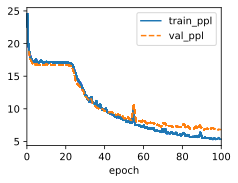

In [ ]:
class StackedRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnns = nn.Sequential(*[
            d2l.RNNScratch(num_inputs if i==0 else num_hiddens, num_hiddens, sigma)
            for i in range(num_layers)])
        
@d2l.add_to_class(StackedRNNScratch)
def forward(self, inputs, Hs=None):
    outputs = inputs # (num_steps, batch_size, num_inputs)
    if Hs is None: Hs = [None] * self.num_layers
    for i in range(self.num_layers):
        # outputs = list of num_steps hidden states(batch_size, num_hiddens)
        # Hs[0] = final hidden state from layer 0 = (batch_size, num_hiddens)
        outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
        # outputs: (num_steps, batch_size, num_hidden) to be feed into next layer
        # For each time step, For each sample in the batch, You have the top-layer hidden state
        # Hs = [
        #   H_final_time_step_in_layer0,  # (batch_size, num_hiddens)
        #   H_final_time_step_in_layer1   # (batch_size, num_hiddens)
        #   ...
        # ]
        # Why does it matter to store final hidden states for each layer?
        #     It only matters if you plan to continue the sequence or do something stateful.
        #     Otherwise, for standard language modeling, it’s mostly bookkeeping.
        outputs = torch.stack(outputs, 0)
    return outputs, Hs

data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn_block = StackedRNNScratch(num_inputs=len(data.vocab),num_hiddens=32, num_layers=2)
model = d2l.RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [ ]:
#  Concise Implementation

class GRU(d2l.RNN):  #@save
    """The multilayer GRU model."""
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, num_layers, dropout=dropout)

gru = GRU(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)

model.predict('it has', 20, data.vocab, d2l.try_gpu())

================================Bidirectional Recurrent Neural Networks==============================

![Bi RNN](./Images/Bi-RNN.png)

1. **Forward hidden state:**
$
\overrightarrow{\mathbf{H}}_t = \phi\left( \mathbf{X}_t \mathbf{W}_{xh}^{(f)} + \overrightarrow{\mathbf{H}}_{t-1} \mathbf{W}_{hh}^{(f)} + \mathbf{b}_h^{(f)} \right)
$

2. **Backward hidden state:**
$
\overleftarrow{\mathbf{H}}_t = \phi\left( \mathbf{X}_t \mathbf{W}_{xh}^{(b)} + \overleftarrow{\mathbf{H}}_{t+1} \mathbf{W}_{hh}^{(b)} + \mathbf{b}_h^{(b)} \right)
$

3. **Concatenated hidden state:**
$
\mathbf{H}_t = [\, \overrightarrow{\mathbf{H}}_t ; \overleftarrow{\mathbf{H}}_t \,]
$

4. **Output:**
$
\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q
$


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
class BiRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.f_rnn = d2l.RNNScratch(num_inputs, num_hiddens, sigma)
        self.b_rnn = d2l.RNNScratch(num_inputs, num_hiddens, sigma)
        self.num_hiddens *= 2  # The output dimension will be doubled

@d2l.add_to_class(BiRNNScratch)
def forward(self, inputs, Hs=None):
    f_H, b_H = Hs if Hs is not None else (None, None)

    f_outputs, f_H = self.f_rnn(inputs, f_H)
    # f_outputs: Forward RNN outputs [H₁→, H₂→, H₃→, ...]")
    # Each Hᵢ→ has shape (batch_size, num_hiddens)")
    
    b_outputs, b_H = self.b_rnn(reversed(inputs), b_H)
    # b_outputs: Backward RNN outputs [H₁←, H₂←, H₃←, ...]")
    # Each Hᵢ← has shape (batch_size, num_hiddens)")

    outputs = [torch.cat((f, b), -1) for f, b in zip(f_outputs, reversed(b_outputs))]
    # torch.cat((f, b), -1): Concatenates along last dimension (feature dimension)")
    # Each Hᵢ has shape (batch_size, num_hiddens * 2)")

    # output shape: list(length num_steps) of (batch_size, num_hiddens * 2)
    return outputs, (f_H, b_H)

In [4]:
# concise implementation

class BiGRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, bidirectional=True)
        self.num_hiddens *= 2

===================================Machine Translation and the Dataset===================================

In [2]:
import os
import torch
from d2l import torch as d2l

In [3]:
class MTFraEng(d2l.DataModule):  #@save
    """The English-French dataset."""
    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

data = MTFraEng()
raw_text = data._download()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [4]:
#  we replace non-breaking space with space, convert uppercase letters to lowercase ones, and insert space between words and punctuation marks.

@d2l.add_to_class(MTFraEng)  #@save
def _preprocess(self, text):
    # Replace non-breaking space with space
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    # Insert space between words and punctuation marks
    no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text.lower())]
    return ''.join(out)

text = data._preprocess(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [5]:
# tokenization 

@d2l.add_to_class(MTFraEng)  #@save
def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
        if max_examples and i > max_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            # Skip empty tokens
            src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
            tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
    return src, tgt

src, tgt = data._tokenize(text)
src[:6], tgt[:6]

([['go', '.', '<eos>'],
  ['hi', '.', '<eos>'],
  ['run', '!', '<eos>'],
  ['run', '!', '<eos>'],
  ['who', '?', '<eos>'],
  ['wow', '!', '<eos>']],
 [['va', '!', '<eos>'],
  ['salut', '!', '<eos>'],
  ['cours', '!', '<eos>'],
  ['courez', '!', '<eos>'],
  ['qui', '?', '<eos>'],
  ['ça', 'alors', '!', '<eos>']])

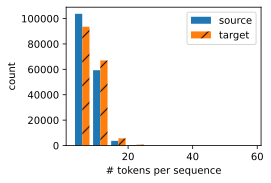

In [6]:
#@save
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """Plot the histogram for list length pairs."""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist([[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence','count', src, tgt)

In [7]:
@d2l.add_to_class(MTFraEng)  #@save
def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
    super(MTFraEng, self).__init__()
    self.save_hyperparameters()
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(self._download())

@d2l.add_to_class(MTFraEng)  #@save
def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
    def _build_array(sentences, vocab, is_tgt=False):
        pad_or_trim = lambda seq, t: (seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
        sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [['<bos>'] + s for s in sentences]
        if vocab is None:
            vocab = d2l.Vocab(sentences, min_freq=2)
        array = torch.tensor([vocab[s] for s in sentences])
        valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
        return array, vocab, valid_len
    src, tgt = self._tokenize(self._preprocess(raw_text),self.num_train + self.num_val)
    src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
    tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
    return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]), src_vocab, tgt_vocab)

In [8]:
@d2l.add_to_class(MTFraEng)  #@save
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader(self.arrays, train, idx)

In [9]:
data = MTFraEng(batch_size=3)
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
print('source:', src.type(torch.int32))
print('decoder input:', tgt.type(torch.int32))
print('source len excluding pad:', src_valid_len.type(torch.int32))
print('label:', label.type(torch.int32))

source: tensor([[ 85,   5,   2,   3,   4,   4,   4,   4,   4],
        [ 86, 120,   2,   3,   4,   4,   4,   4,   4],
        [ 84, 157,   2,   3,   4,   4,   4,   4,   4]], dtype=torch.int32)
decoder input: tensor([[  3, 108,   6,   2,   4,   5,   5,   5,   5],
        [  3, 108, 202,  30,   2,   4,   5,   5,   5],
        [  3, 111,   6,   2,   4,   5,   5,   5,   5]], dtype=torch.int32)
source len excluding pad: tensor([4, 4, 4], dtype=torch.int32)
label: tensor([[108,   6,   2,   4,   5,   5,   5,   5,   5],
        [108, 202,  30,   2,   4,   5,   5,   5,   5],
        [111,   6,   2,   4,   5,   5,   5,   5,   5]], dtype=torch.int32)


In [10]:
@d2l.add_to_class(MTFraEng)  #@save
def build(self, src_sentences, tgt_sentences):
    raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
        src_sentences, tgt_sentences)])
    arrays, _, _ = self._build_arrays(
        raw_text, self.src_vocab, self.tgt_vocab)
    return arrays

src, tgt, _,  _ = data.build(['hi .'], ['salut .'])
print('source:', data.src_vocab.to_tokens(src[0].type(torch.int32)))
print('target:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

source: ['hi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'salut', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


=======================================The Encoder–Decoder Architecture=====================================


### Encoder–Decoder Architecture

#### What is Encoder–Decoder
- An architecture for handling **variable‑length input and output sequences**.
- Used in translation, summarization, speech recognition, caption generation.
- Consists of:
  - **Encoder** → reads input sequence and compresses it into a **context representation**.
  - **Decoder** → generates output sequence conditioned on encoder representation.

#### Structure

##### Encoder
- Processes tokens step by step (often with an RNN / LSTM / GRU).
- Produces hidden states; the final one becomes the **context vector**.
- Handles variable input length naturally.

##### Decoder
- Initialized from encoder context.
- Generates tokens sequentially, typically autoregressively.
- Training often uses **teacher forcing**.

#### Why it Works
- It allows different input/output lengths → far more general than classification.
- Core idea: compress full sentence meaning into a vector, then expand into output.

#### Limitation
- **Single context vector bottleneck** limits performance on long sequences.
- Decoder may struggle to remember whole input if compressed too aggressively.
- Solution later: **Attention mechanism**, allowing access to all encoder states.

![encoder-decoder](./Images/encoder-decoder1.png)

In [11]:
from torch import nn
from d2l import torch as d2l

In [12]:
class Encoder(nn.Module):  #@save
    """The base encoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def forward(self, X, *args):
        raise NotImplementedError

In [13]:
class Decoder(nn.Module):  #@save
    """The base decoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def init_state(self, enc_all_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [14]:
class EncoderDecoder(d2l.Classifier):  #@save
    """The base class for the encoder--decoder architecture."""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]

===================================Sequence-to-Sequence Learning for Machine Translation================================

![RNN-encoder-decoder](./Images/RNN-encoder-decoder.png)

![RNN-encoder-decoder](./Images/RNN-encoder-decoder-2.png)

In [15]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

vocab_size = the number of unique tokens in your vocabulary, including any special tokens.

Why does nn.Embedding need vocab_size?
  - Because the embedding layer is essentially a lookup table, not a neural network layer in the usual sense.
  - Embedding = a matrix of shape [vocab_size, embed_size]

In [ ]:
def init_seq2seq(module):  #@save
    """Initialize weights for sequence-to-sequence learning."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        # what does module.apply(fn) does:
        #  - It walks through self and every module inside it
        #  - For each module, it calls function fn(submodule)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)  hidden state at each time step (last layer only)
        # state   shape: (num_layers, batch_size, num_hiddens) final hidden state for each layer (last time step only)
        return outputs, state

In [17]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))

In [18]:
d2l.check_shape(enc_state, (num_layers, batch_size, num_hiddens))

tensor.repeat(a, b, c)
 - copy along dim0   a times
 - copy along dim1   b times
-  copy along dim2   c times

In [ ]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        # enc_all_outputs = (enc_outputs, enc_state) what encoder returned
        return enc_all_outputs

    def forward(self, X, state):
        # X shape:    (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))

        # in GRU (and RNN/LSTM):
        #   enc_all_outputs.enc_outputs shape: (num_steps, batch_size, num_hiddens)  hidden state at each time step (last layer only)
        #   enc_all_outputs.enc_state   shape: (num_layers, batch_size, num_hiddens) final hidden state for each layer (last time step only)
        #   enc_all_outputs.enc_outputs[-1]: The output from the final layer at the last time step
        #   enc_all_outputs.enc_state[-1]:   The final hidden state of the final layer
        # These two are identical because in RNN architectures, the "output" at any time step is the hidden state at that time step. 
        # There's no additional transformation - the hidden state is directly used as the output.
        enc_output, hidden_state = state
        
        # context shape: (batch_size, hidden_state)
        context = enc_output[-1]

        # Broadcast context to (num_steps, batch_size, num_hiddens), same context vector copied for each time step
        context = context.repeat(embs.shape[0], 1, 1)

        # Concat at last dimension (feature dimension)
        # embs_and_context: (num_steps, batch_size, embed_size + num_hiddens)
        embs_and_context = torch.cat((embs, context), -1)

        # outputs shape:      (num_steps, batch_size, num_hiddens)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        # more about previous line: embs_and_context and hidden_state come from the encoder, but they serve different purposes inside the decoder.
        # hidden_state updates in every subsequent steps  → dynamic decoder state
        # context inside embs_and_context stays constant  → background information

        # outputs shape: (batch_size, num_steps, vocab_size)
        outputs = self.dense(outputs).swapaxes(0, 1)

        return outputs, [enc_output, hidden_state]

#### Encoder: time-major (num_steps, batch_size, hidden)

Why this layout?

The encoder is a pure recurrent computation over time.

	• RNN/GRU/LSTM in PyTorch natively operate time-major
	• Time-major is cache-friendly and avoids extra transposes inside the RNN loop
	• Encoder outputs are mostly used internally:
	    • passed to the decoder as state
	    • sliced by time index (enc_output[-1])
	    • used by attention (which usually expects time-major)

So D2L keeps: enc_outputs: (num_steps, batch_size, num_hiddens) , this matches with "outputs, state = self.rnn(X, state)"

#### Decoder: batch-major (batch_size, num_steps, vocab_size)

The decoder has a very different downstream consumer.

Who consumes decoder output?

	• Loss function (nn.CrossEntropyLoss)
	• Evaluation / inference
	• Beam search
	• Metrics

And all of these expect: (batch_size, sequence_length, vocab_size)

Why?

	• Training data labels are (batch_size, num_steps)
	• Loss is computed per sequence per batch
	• This layout avoids permuting tensors every training step

So after the RNN:
	outputs = self.dense(outputs)          # (num_steps, batch_size, vocab_size)
	outputs = outputs.swapaxes(0, 1)       # (batch_size, num_steps, vocab_size)

This is a deliberate interface decision, not an accident.


In [20]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))

/workspaces/pytorch-basics/.venv310/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [21]:
class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [22]:
@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
    return (l * mask).sum() / mask.sum()

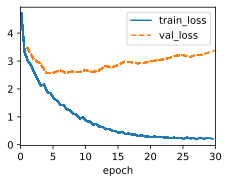

In [23]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [ ]:
@d2l.add_to_class(d2l.EncoderDecoder)  #@save
def predict_step(self, batch, device, num_steps, save_attention_weights=False):
    batch = [a.to(device) for a in batch]
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)

    #  tgt[:, (0)] → Extracts the first column (all <bos> tokens) → shape: (batch_size,)
    #  .unsqueeze(1) → Adds a sequence dimension → shape: (batch_size, 1)
    #  [..., ] → Puts it in a list to accumulate generated tokens
    outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
    # outputs = [tensor1], tensor1 shape: (batch_size, 1) all <bos> tokens
    for _ in range(num_steps):
        # Y shape: (batch_size, 1, vocab_size)
        Y, dec_state = self.decoder(outputs[-1], dec_state)

        #  choose highest predicted probability, next section will talk another option: beam search
        outputs.append(Y.argmax(2))
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return torch.cat(outputs[1:], 1), attention_weights


# Each step predicts one new token using the accumulated decoder hidden state, but only the last predicted token is fed back as input.
# Not the whole prefix. Not the whole output history.
# Just one token per step.

#### BLEU
BLEU (Bilingual Evaluation Understudy) — a widely used automatic evaluation metric for sequence outputs (especially translation).

Denote by $p_n$ the precision of an n-gram, defined as the ratio of the number of matched n-grams in the predicted and target sequences to the number of n-grams in the predicted sequence. To explain, given a target sequence A, B, C, D, E and a predicted sequence A, B, B, C, D. we have 
$p_1=4/5$, $p_2=3/4$, $p_3=1/3$ and $p_4=0$. Now let $len_{label}$ and $len_{pred}$ be the numbers of tokens in the target sequence and the predicted sequence, respectively. Then, BLEU is defined as:
$$
\text{BLEU} = \exp \left( 
    \min \left( 0, 1 - \frac{\text{len}_{\text{label}}}{\text{len}_{\text{pred}}} \right)
\right)
\prod_{n=1}^{k} p_n^{1/2^n},
$$.
Since matching longer n-grams is more difficult, BLEU assigns a greater weight when a longer n-gram has high precision. 


In [25]:
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [26]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


===============================================Beam Search===============================================

Beam search maintains a fixed number k of the best partial sequences (the beam).
At each decoding step:

	1.	Expand each candidate in the beam with every possible next token.
	2.	Compute the scores for all expanded sequences.
	3.	Select the top k scoring candidates to form the new beam.

By keeping only the top k candidates:

	•	Beam search reduces computation compared to exhaustive search.
	•	Larger beam sizes generally improve quality (more candidates) but increase cost.
	•	A beam size of 1 reduces to greedy search.

Beam search provides a trade-off between accuracy and efficiency via the beam size.

![beam search](./Images/beam-search.png)